<p> This notebook provides an update to the IPCC AR6 Earth energy inventory assessment timeseries and saves the data to file.</p> 

In [9]:
%matplotlib inline
import iris
import scipy.io
import pickle 
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from datetime import date
import os.path

1971.5 2023.5


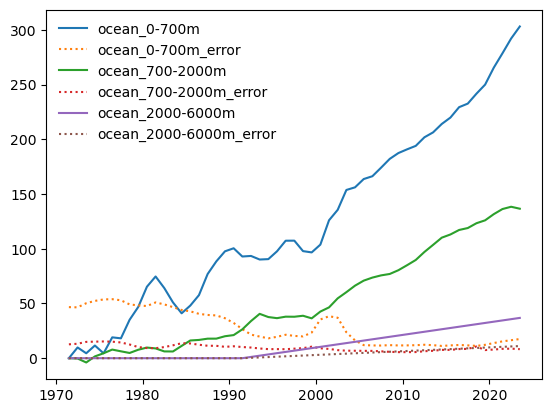

[  1.54098582  11.77562452   4.25804291  15.76150775  11.99020804
  29.38713272  28.53845182  44.50792528  60.28799377  82.07973754
  91.15480707  77.9049049   65.00633235  59.52055723  71.5002179
  82.42361373 103.26078169 117.1024239  128.5442364  133.33949147
 131.6276436  139.14744393 143.77798104 143.90636445 152.42417178
 165.79497989 166.83317806 162.52557006 159.58518401 174.3664909
 202.99225667 223.13101012 248.28577548 258.74891165 274.00999188
 282.01181806 294.09087708 305.03541783 316.57607404 328.12117201
 337.64316209 354.9305599  368.30964013 383.83695845 394.9857702
 413.12702587 420.58234099 435.31099123 448.71318826 473.01771325
          nan          nan          nan]
[493.69929372 512.09270031 523.4795135 ]
[1971.5 1972.5 1973.5 1974.5 1975.5 1976.5 1977.5 1978.5 1979.5 1980.5
 1981.5 1982.5 1983.5 1984.5 1985.5 1986.5 1987.5 1988.5 1989.5 1990.5
 1991.5 1992.5 1993.5 1994.5 1995.5 1996.5 1997.5 1998.5 1999.5 2000.5
 2001.5 2002.5 2003.5 2004.5 2005.5 2006.5 2007.

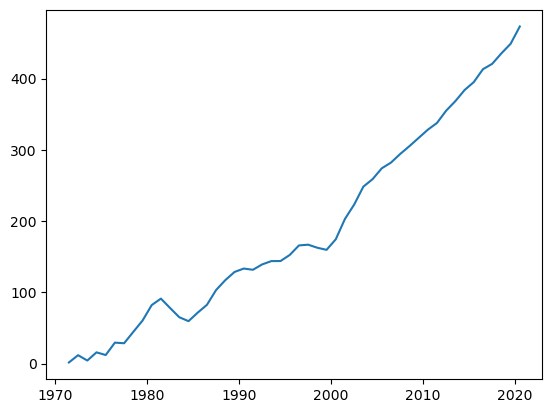

In [13]:
ar6dir = os.path.expanduser('~/python/ar6/src/notebooks/FGD/data/')
ohcdir = os.path.expanduser('~/python/IGCC/src/notebooks/data/')
ncdir  = os.path.expanduser('~/Data/GCOS/') 

# Load in the IPCC AR6 timeseries..
ar6file   = 'AR6_energy_GMSL_timeseries_FGD_1971to2018_corrigendum.pickle' # Include IMBIE update from 10.03.21
data = pickle.load( open( ar6dir + ar6file, 'rb' ) )
energy_ar6 = data['energy_dict']
ar6yrs = energy_ar6['yrs']

# Load in the updated OHC timeseries..
ohcfile = 'AR6_OHC_ensemble_IGCC_update_2024-04-13.pickle'
ensm_ohc = pickle.load( open( ohcdir + ohcfile, 'rb' ) )['ensm_ohc_dict']
updyrs = ensm_ohc['yrs'] # Get years for updated timeseries, 1971.5 to 2023.5 
fyr    = updyrs[0] # Get first year for update timeseries
lyr    = updyrs[-1] # Get last year for update timeseries 

print(fyr, lyr)

ncfile_dict = {'atmosphere':'GCOS_EHI_1960-2020_Atmosphere_Heat_Content_data.nc',
               'cryosphere':'GCOS_EHI_1960-2020_Cryosphere_Heat_Content_data.nc', 
               'land':'GCOS_EHI_1960-2020_Continental_Heat_Content_data.nc'}

varname_dict = {'atmosphere':'Atmospheric Heat Content',
               'cryosphere':'Cryosphere Heat Content', 
               'land':'Continental Heat Content'}

energy_update = {} # Initiate dictionary to store energy inventory updated timeseries.. 

fyr    = updyrs[0] # Get first year for update timeseries
lyr    = updyrs[-1] # Get last year for update timeseries 

energy_update['yrs'] = updyrs

for comp in ['atmosphere', 'cryosphere', 'land']:
    series  = np.zeros_like(updyrs) # Initiate Numpy array for heat content timeseries 
    ncfile  = ncfile_dict[comp]
    varname = varname_dict[comp]
    cube    = iris.load_cube(ncdir + ncfile, varname)
    yrs     = np.arange(cube.data.shape[0]) + 1960.5 # Get year values for *.nc data 
    ind1    = np.where((yrs >= fyr) & (yrs <= lyr))[0]
    ind2    = np.where((updyrs >= yrs[ind1[0]]) & (updyrs <= yrs[ind1[-1]]))[0]
    series[ind2] = cube.data[ind1]
    series[-3], series[-2], series[-1]   = np.nan, np.nan, np.nan # Data available to end of 2020, so make NaN for 2021, 2022.  
    energy_update[comp] = series

for comp in ['ocean_0-700m', 'ocean_700-2000m']:
    series = np.zeros_like(updyrs) # Array for OHC timeseries
    eseries = np.zeros_like(updyrs) # Array for error timeseries 
    # Splice the timeseries at 2018.5..
    ohc1 = energy_ar6[comp]
    ohc2 = ensm_ohc[comp]
    ohc_err1 = energy_ar6[comp + '_error']
    ohc_err2 = ensm_ohc[comp + '_error']
    ind1 = np.where((ar6yrs >= fyr) & (ar6yrs <= lyr))[0]
    ind2 = np.where((updyrs >=ar6yrs[ind1[0]]) & (updyrs <= ar6yrs[ind1[-1]]))[0]
    series[ind2] = ohc1[ind1]
    eseries[ind2] = ohc_err1[ind1]
    ind1 = np.where(ar6yrs == 2018.5)[0][0]
    ind2 = np.where(updyrs == 2018.5)[0][0]
    offset = ohc1[ind1] - ohc2[ind2] # Calculate offset needed to splice the timeseries at 2018.5 
    series[-5:] = ohc2[-5:] + offset
    eseries[-5:] = ohc_err2[-5:]

    plt.plot(updyrs, series, label=comp)
    plt.plot(updyrs, eseries, label=comp + '_error', linestyle=':')

    energy_update[comp] = series
    energy_update[comp + '_error'] = eseries
    
energy_update['ocean_2000-6000m'] = ensm_ohc['ocean_2000-6000m']
energy_update['ocean_2000-6000m_error'] = ensm_ohc['ocean_2000-6000m_error']

plt.plot(updyrs, energy_update['ocean_2000-6000m'], label='ocean_2000-6000m')
plt.plot(updyrs, energy_update['ocean_2000-6000m_error'], label='ocean_2000-6000m_error', linestyle=':')
    
plt.legend(loc='upper left', frameon=False)    
plt.show()

energy_update['ocean_full-depth'] = energy_update['ocean_0-700m'] + energy_update['ocean_700-2000m'] + energy_update['ocean_2000-6000m']
energy_update['Total'] = energy_update['atmosphere'] + energy_update['cryosphere'] + energy_update['land'] + energy_update['ocean_full-depth']
energy_update['Units'] = 'ZJ'
plt.plot(updyrs, energy_update['Total'])
print(energy_update['Total'])

ratio = 1.0/0.91 # Ocean heat content represents about 91% of heat uptake.. 
print(energy_update['ocean_full-depth'][-3:] * ratio)

print(energy_update['yrs'])

print(energy_update.keys())

In [14]:
savedir = os.path.expanduser('~/python/IGCC/src/notebooks/data/')
datestr = date.isoformat(date.today()) # Get string to represent processing date

pickle_file = 'IGCC_AR6_update_energy_timeseries_1971to2023_'+datestr+'.pickle'

# SAVE THE DATA TO FILE.. 
print("SAVING:", savedir + pickle_file)
pickle.dump( energy_update, open( savedir+pickle_file, "wb" ) )

SAVING: /Users/lk21862/python/IGCC/src/notebooks/data/IGCC_AR6_update_energy_timeseries_1971to2023_2024-04-13.pickle


In [15]:
# Load the file back in and check dictionary keys.. 
energy_dict = pickle.load( open( savedir + pickle_file, 'rb' ) )

print(energy_dict.keys())

dict_keys(['yrs', 'atmosphere', 'cryosphere', 'land', 'ocean_0-700m', 'ocean_0-700m_error', 'ocean_700-2000m', 'ocean_700-2000m_error', 'ocean_2000-6000m', 'ocean_2000-6000m_error', 'ocean_full-depth', 'Total', 'Units'])
